## **Import Libraries**

In [2]:
## Test if GPU is activated
# import tensorflow as tf
# tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Baisc Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import joblib
import pickle

import os
from pathlib import Path
import glob
from tqdm import tqdm
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

# Text processing Libraries
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import punctuation 
from wordcloud import WordCloud, STOPWORDS
!pip install thefuzz
from thefuzz import fuzz
# from distance import distance

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score,  accuracy_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
# !pip install xgboost-gpu

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, concatenate, LSTM, CuDNNLSTM, Dense, BatchNormalization, Dropout
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# New Section

##**Load Dataset**

In [4]:
# mounting the drive
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/1_Quora/

/content/drive/MyDrive/Colab Notebooks/ML_CaseStudies/1_Quora


In [6]:
# # load the train and test data frames with customised features from parquet file 
dir_name = "data/"
x_train_features  = pd.read_parquet(dir_name+'x_train_features.parquet')
x_test_features = pd.read_parquet(dir_name+'x_test_features.parquet')
y_train = pd.read_parquet(dir_name+'y_train.parquet')
y_test = pd.read_parquet(dir_name+'y_test.parquet')

In [7]:
x_train_features.head()

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,freq_q1+q2,q1len,q2len,q1_n_words,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_set_ratio,token_sort_ratio
179028,274801,274802,mani state anthem india,india chang nation anthem speak manipur state,1,1,0,47,91,9,...,0.222220,0.124999,0.0,0.0,7.0,12.5,19,47,55,46
155911,244152,244153,futur app,futur app,1,1,0,20,26,4,...,0.749981,0.499992,1.0,1.0,2.0,5.0,78,70,89,70
51688,91649,91650,best weekend mba program india,everyon love ciel phantomh sebastian,1,1,0,48,48,9,...,0.000000,0.000000,0.0,0.0,2.0,8.0,29,36,12,12
273097,391494,176735,eat tomato sauc pasta paleo diet carb pasta co...,best sauc spinach pasta,1,2,1,127,52,26,...,0.181817,0.080000,0.0,0.0,14.0,18.0,26,44,49,42
281356,401118,401119,key west fl miami fl compar,key west fl miami fl differ,1,1,0,39,38,9,...,0.777769,0.777769,0.0,1.0,0.0,9.0,86,87,89,86


In [8]:
x_train = x_train_features.drop(["qid1", "qid2"], axis =1)
x_test = x_test_features.drop(["qid1", "qid2"], axis =1)

In [9]:
x_train.columns

Index(['question1', 'question2', 'freq_qid1', 'freq_qid2', 'freq_q1+q2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio',
       'token_sort_ratio'],
      dtype='object')

## **4. Deep Learning Model Using LSTM**

### **4.0 Functions**

In [10]:
def heatmp_mat(M, name, ax):
    """ This function represents confusion matrix in heatmap format """

    labels = [0,1]
    cmap =sns.light_palette("blue") #"YlGnBu"
    sns.heatmap(M, annot=True,  fmt=".3f", cmap = cmap, xticklabels=labels, yticklabels=labels, ax =ax)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Original Class')
    ax.set_title(name)

def plot_confusion_matrix(test_y, predict_y):
    """ This function plots the confusion matrices given test_y, predict_y """

    C = confusion_matrix(test_y, predict_y)
    B =(C/C.sum(axis=0))
    A =(((C.T)/(C.sum(axis=1))).T)

    fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
    heatmp_mat(C, "Confusion matrix", ax = ax[0])
    heatmp_mat(B, "Precision matrix (Columm Sum=1)", ax = ax[1])
    heatmp_mat(A, "Recall matrix (Row sum=1)", ax = ax[2])
    fig.suptitle("Confusion Matrix for Test Data")
    plt.show()

def print_scores(test_y, predict_y):
    """ This function calculates and prints the scores given test_y, predict_y """

    acc_test = accuracy_score(test_y,predict_y)*100
    print("test accuracy  is {0:.2f}%".format(acc_test))
    precision = precision_score(test_y,predict_y, average = 'weighted')*100
    print("precision score : {0:.2f}%".format(round(precision,2)))
    recall= recall_score(test_y,predict_y, average = 'weighted')*100
    print("Recall score : {0:.2f}%" .format(round(recall,2)))
    f1score = f1_score(test_y,predict_y, average = 'weighted')*100
    print("F1-score : {0:.2f}%".format(round(f1score,2)))
    return

### **4.1 Create Word embeddings using pretrained glove vectors**

* tokenize
* Integer encode the texts (convert text to sequences)
* pad the sequences
* load word vectors from glove
* create embedding matrix

#### Calculating the Vocab size and the maximum sequence length 

In [11]:
# making a list of all 'question1' and 'question2' in entire training data
train_questions = x_train["question1"].to_list() + x_train["question2"].to_list()

# to find the total vocab size in both 'question1' and 'question2'
vocab_set = set()
for s in train_questions:
    for w in s.split(" "):
        if w != " ":
            vocab_set.add(w)

print("The total voacb size including question1 and question2 over the entire training data: ", len(vocab_set))

# to find the optimum max-length of the sequences
lengths = [len(s) for s in train_questions]
lengths = sorted(lengths)

print("90 percentile sequence length '", np.percentile(lengths,90))
print("99.9 percentile sequence length ", np.percentile(lengths,99.9))
print("100 percentile sequence length ", np.percentile(lengths,100))

The total voacb size including question1 and question2 over the entire training data:  73638
90 percentile sequence length ' 58.0
99.9 percentile sequence length  145.0
100 percentile sequence length  580.0


In [12]:
# fit the tokenizer on all the 'question1' and 'question2' in whole training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['question1'] + x_train['question2'])
vocab_size = len(tokenizer.word_index) + 1

# interger encode the documents
train_seq1 = tokenizer.texts_to_sequences(x_train['question1'])
train_seq2 = tokenizer.texts_to_sequences(x_train['question2'])

test_seq1 = tokenizer.texts_to_sequences(x_test['question1'])
test_seq2 = tokenizer.texts_to_sequences(x_test['question2'])

# # pad the sequences to a certain max_len
max_seq_len = 150

x_train_seq1 = pad_sequences(train_seq1, maxlen = max_seq_len, padding = 'post')
x_train_seq2 = pad_sequences(train_seq2, maxlen= max_seq_len, padding = 'post')

x_test_seq1 = pad_sequences(test_seq1, maxlen = max_seq_len, padding = 'post')
x_test_seq2 = pad_sequences(test_seq2, maxlen = max_seq_len, padding = 'post')

In [14]:
### download the glove vectors
# !wget -P /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/glove/ http://nlp.stanford.edu/data/glove.6B.zip
# !unzip /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/glove*.zip -d /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/glove

### load the whole glove embedding into memory as a dictionary
file_to_open = "../glove/glove.6B.100d.txt"
f = open(file_to_open)

embeddings_index = dict()
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

### create a embedding matrix for the words in training docs
embedding_matrix = np.zeros((vocab_size,100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train.iloc[:,2:])
x_train_num = scaler.transform(x_train.iloc[:,2:])
x_test_num = scaler.transform(x_test.iloc[:,2:])

### <font color = "blue"> **4.2 Model -1**

using Keras Functional API

In [ ]:
# Define input layers
text_input_q1 = keras.Input(shape = len(x_train_seq1[0]))
text_input_q2 = keras.Input(shape = len(x_train_seq2[0]))
numeric_input = keras.Input(shape= len(x_train_num[0]))

# Define embedding layer for text inputs
embedded_layer = Embedding(vocab_size, 100, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)

# Process text inputs with Embedding and LSTM layers
embedded_q1 = embedded_layer(text_input_q1)
lstm__q1 = LSTM(units = 16, dropout = 0.5, recurrent_dropout = 0.5, 
                 kernel_initializer=tf.keras.initializers.HeNormal , kernel_regularizer=tf.keras.regularizers.l2())(embedded_q1)

embedded_q2 = embedded_layer(text_input_q2)
lstm__q2 = LSTM(units = 16, dropout = 0.5, recurrent_dropout = 0.5, 
                 kernel_initializer=tf.keras.initializers.HeNormal , kernel_regularizer=tf.keras.regularizers.l2())(embedded_q2)

# Concatenate LSTM outputs and numeric input
concatenated_input = concatenate([lstm__q1, lstm__q2, numeric_input], axis = -1)

# Apply batch normalization and dropout regularization
batchnorm_1 = BatchNormalization()(concatenated_input)
dropout_1 = Dropout(rate = 0.5)(batchnorm_1)

# Apply fully connected layers
dense_1 = Dense(units = 16, activation="relu",
                      kernel_initializer=tf.keras.initializers.HeNormal , kernel_regularizer=tf.keras.regularizers.l2())(dropout_1)
batchnorm_2 = BatchNormalization()(dense_1)
dropout_2 = Dropout(rate = 0.5)(batchnorm_2)

# Apply output layer with sigmoid activation for binary classification
output_layer = Dense(1, activation="sigmoid",
                     kernel_initializer= tf.keras.initializers.HeNormal())(dropout_2)

# Define the model with all input and output layers
model_1 = keras.Model(inputs = [text_input_q1, text_input_q2, numeric_input], 
                      outputs = output_layer, name="LSTM-Model")

# Summarize the model
model_1.summary()

Model: "LSTM-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 100)     24073200    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 16)           7488        ['embedding[0][0]']     

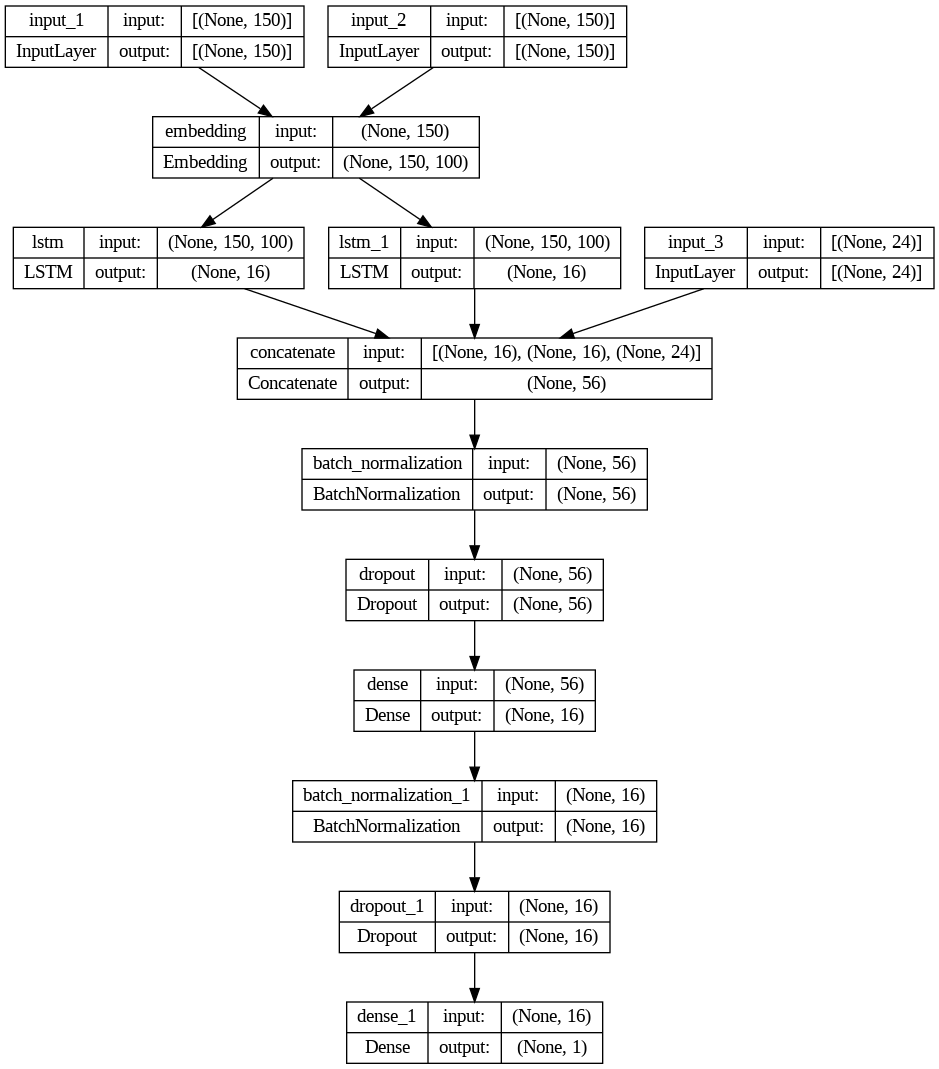

In [ ]:
tf.keras.utils.plot_model(model_1,to_file = 'model1.png',show_shapes=True,show_layer_names=True)

In [ ]:
# call backs

# model checkpoint to save the model
checkpoint = keras.callbacks.ModelCheckpoint(filepath ="model_save/best_model_1.h5", save_best_only = True, monitor = "val_loss", mode = 'auto', verbose = 1)

# reduce learning rate on plateau
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_delta=0.0001, mode="auto")

# early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, min_delta = 0.0001, verbose =1, mode= "auto")

# tensorboard
log_dir = "logs/model_1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# compile the model
model_1.compile(
    optimizer = keras.optimizers.Adam(clipvalue = 0.5, clipnorm =1),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
    )

# fit the model on training data
model_1.fit([x_train_seq1, x_train_seq2, x_train_num], y_train, 
             validation_split = 0.2, epochs = 5, 
            batch_size= 128,
            callbacks = [checkpoint, reduceLR, early_stopping, tensorboard_callback])

In [ ]:
# load the saved model
loaded_model = tf.keras.saving.load_model("model_save/best_model_1.h5")

# evaluate the model on test data
test_scores = loaded_model.evaluate([x_test_seq1, x_test_seq2, x_test_num], y_test, verbose=1)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

# predict using the model on test data
y_pred = loaded_model.predict([x_test_seq1, x_test_seq2, x_test_num])

# using threshold to convert y_pred into classes
y_pred_class = [1 if x>=0.5 else 0 for x in y_pred]

The logloss on test data is 0.47657194503006084
test accuracy  is 75.28%
precision score : 74.80%
Recall score : 75.28%
F1-score : 74.72%


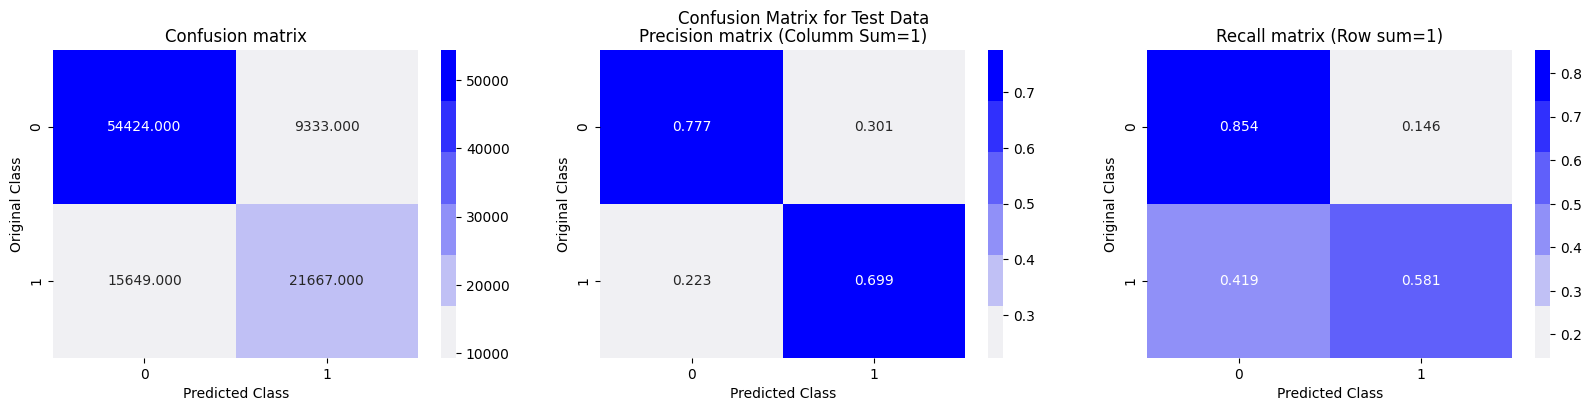

In [ ]:
print("The logloss on test data is", log_loss(y_test, y_pred, eps=1e-15))
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

### <font color = "blue"> **4.3 Model -2**

using Keras Functional API

In [16]:
# Define input layers
text_input_q1 = keras.Input(shape = len(x_train_seq1[0]))
text_input_q2 = keras.Input(shape = len(x_train_seq2[0]))
numeric_input = keras.Input(shape= len(x_train_num[0]))

# Define embedding layer for text inputs
embedded_layer = Embedding(vocab_size, 100, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)

# Process text inputs with Embedding and LSTM layers
# Note: CuDNNLSTM layer requires GPU that supports the cuDNN library
embedded_q1 = embedded_layer(text_input_q1)
lstm__q1 = CuDNNLSTM(units = 32,
                 kernel_initializer=tf.keras.initializers.HeNormal , kernel_regularizer=tf.keras.regularizers.l2())(embedded_q1)

embedded_q2 = embedded_layer(text_input_q2)
lstm__q2 = CuDNNLSTM(units = 32,
                 kernel_initializer=tf.keras.initializers.HeNormal , kernel_regularizer=tf.keras.regularizers.l2())(embedded_q2)

# Concatenate LSTM outputs and numeric input
concatenated_input = concatenate([lstm__q1, lstm__q2, numeric_input], axis = -1)

# Apply batch normalization and dropout regularization
batchnorm_1 = BatchNormalization()(concatenated_input)
dropout_1 = Dropout(rate = 0.5)(batchnorm_1)

# Apply fully connected layers
dense_1 = Dense(units = 64, activation="relu",
                      kernel_initializer=tf.keras.initializers.HeNormal , kernel_regularizer=tf.keras.regularizers.l2())(dropout_1)
batchnorm_2 = BatchNormalization()(dense_1)
dropout_2 = Dropout(rate = 0.5)(batchnorm_2)

# Apply output layer with sigmoid activation for binary classification
output_layer = Dense(1, activation="sigmoid",
                     kernel_initializer= tf.keras.initializers.HeNormal())(dropout_2)

# Define the model with all input and output layers
model_2 = keras.Model(inputs = [text_input_q1, text_input_q2, numeric_input], 
                      outputs = output_layer, name="LSTM-Model-2")

# Summarize the model
model_2.summary()

Model: "LSTM-Model-2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 100)     24073200    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 cu_dnnlstm (CuDNNLSTM)         (None, 32)           17152       ['embedding[0][0]']   

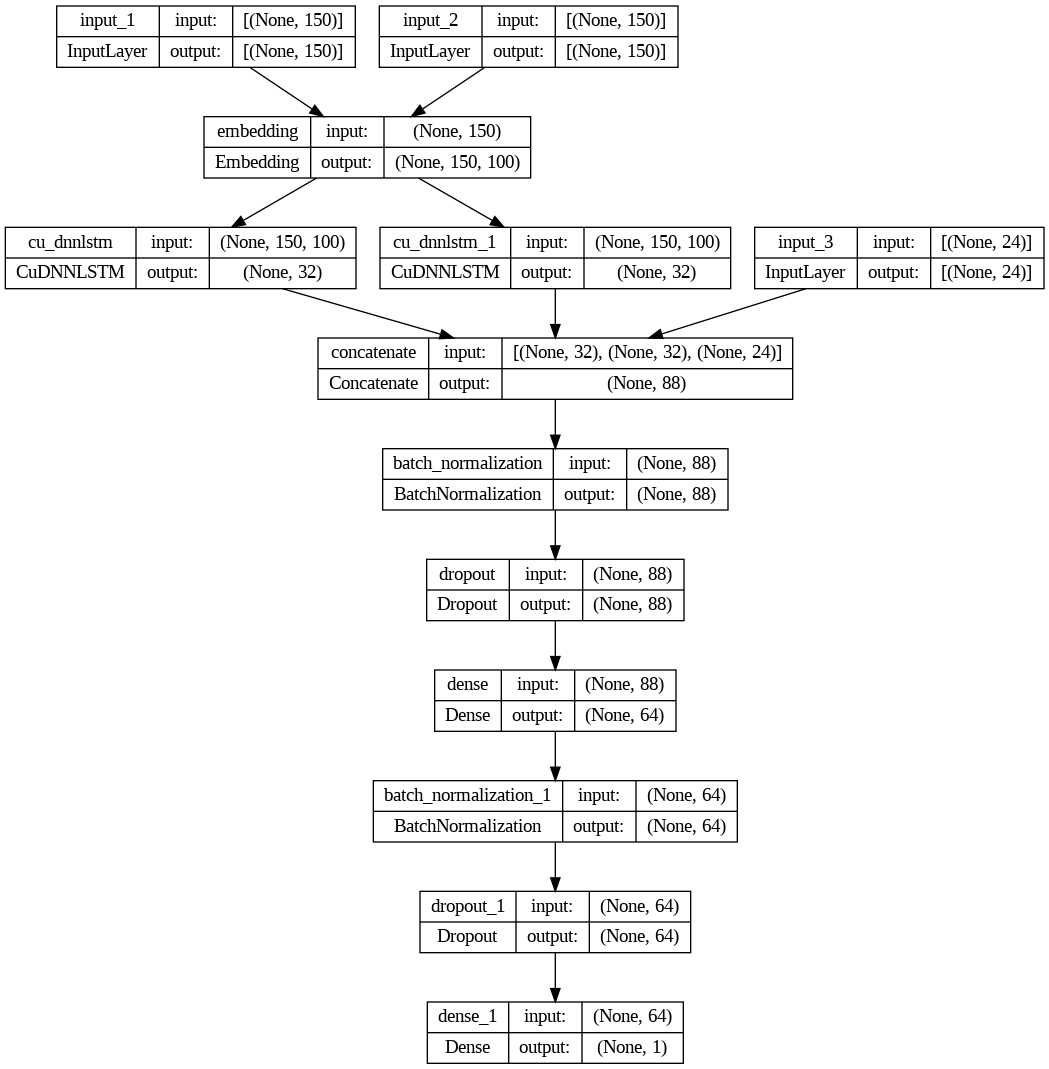

In [17]:
tf.keras.utils.plot_model(model_2,to_file = 'model2.png',show_shapes=True,show_layer_names=True)

In [18]:
# call backs

# model checkpoint to save the model
checkpoint = keras.callbacks.ModelCheckpoint(filepath ="model_save/best_model_2.h5", save_best_only = True, monitor = "val_loss", mode = 'auto', verbose = 1)

# reduce learning rate on plateau
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_delta=0.0001, mode="auto")

# early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, min_delta = 0.0001, verbose =1, mode= "auto")

# tensorboard
log_dir = "logs/model_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
# compile the model
model_2.compile(
    optimizer = keras.optimizers.Adam(clipvalue = 0.5, clipnorm =1),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
    )

# fit the model on training data
history_2 = model_2.fit([x_train_seq1, x_train_seq2, x_train_num], y_train, 
             validation_split = 0.2, epochs = 100, 
            batch_size= 128,
            callbacks = [checkpoint, reduceLR, early_stopping, tensorboard_callback])

Epoch 1/100
1896/1896 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.7378
Epoch 1: val_loss did not improve from 0.44006
1896/1896 [==============================] - 46s 21ms/step - loss: 0.4814 - accuracy: 0.7378 - val_loss: 0.4423 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 2/100
1895/1896 [============================>.] - ETA: 0s - loss: 0.4812 - accuracy: 0.7369
Epoch 2: val_loss did not improve from 0.44006
1896/1896 [==============================] - 36s 19ms/step - loss: 0.4812 - accuracy: 0.7369 - val_loss: 0.4447 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 3/100
1894/1896 [============================>.] - ETA: 0s - loss: 0.4812 - accuracy: 0.7360
Epoch 3: val_loss improved from 0.44006 to 0.43965, saving model to model_save/best_model_2.h5
1896/1896 [==============================] - 59s 31ms/step - loss: 0.4813 - accuracy: 0.7360 - val_loss: 0.4396 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 4/100
1895/1896 [============================>.] - ETA: 0s - los

In [24]:
print(history_2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


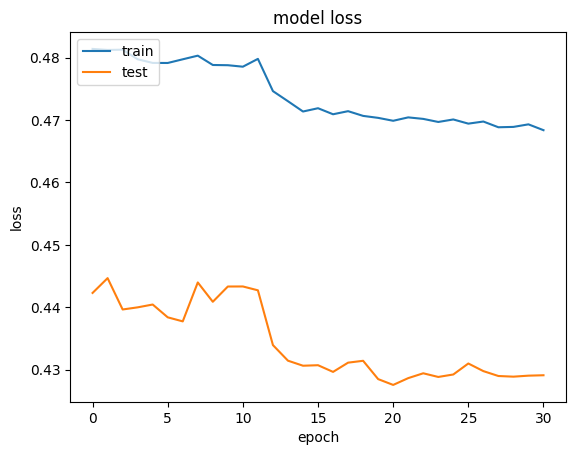

In [25]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

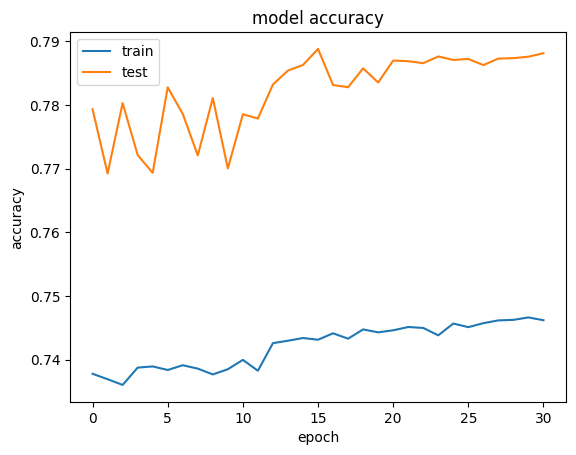

In [26]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# load the saved model
loaded_model = tf.keras.saving.load_model("model_save/best_model_2.h5")

# evaluate the model on test data
test_scores = loaded_model.evaluate([x_test_seq1, x_test_seq2, x_test_num], y_test, verbose=1)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

# predict using the model on test data
y_pred = loaded_model.predict([x_test_seq1, x_test_seq2, x_test_num])

# using threshold to convert y_pred into classes
y_pred_class = [1 if x>=0.5 else 0 for x in y_pred]

3159/3159 [==============================] - 23s 7ms/step - loss: 0.4610 - accuracy: 0.7636
Test loss: 0.46101096272468567
Test accuracy: 0.7635965943336487
3159/3159 [==============================] - 20s 6ms/step


The logloss on test data is 0.4592258954671954
test accuracy  is 76.36%
precision score : 76.01%
Recall score : 76.36%
F1-score : 75.56%


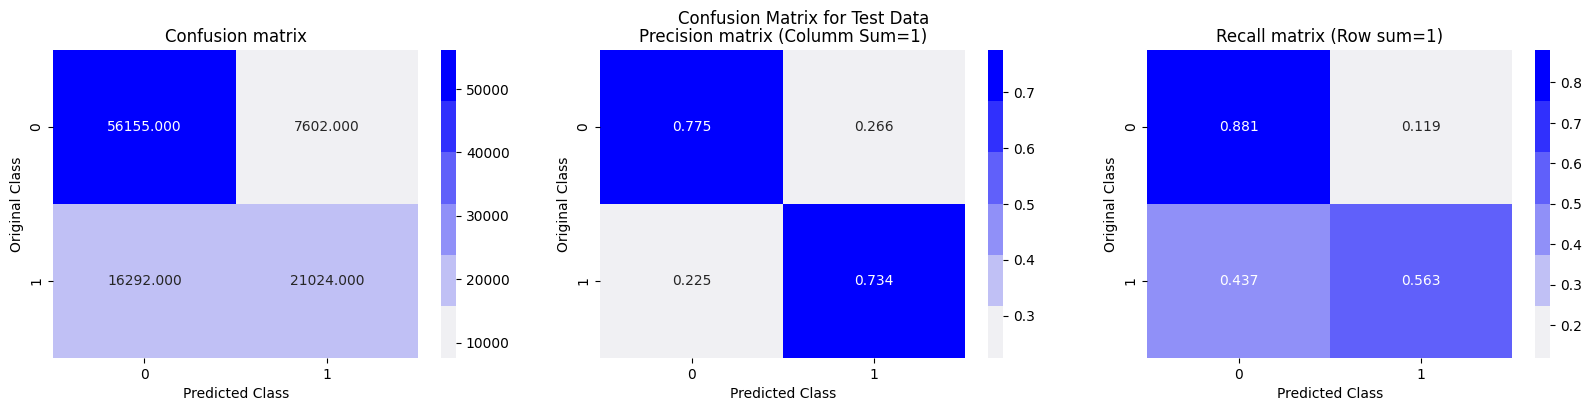

In [23]:
print("The logloss on test data is", log_loss(y_test, y_pred, eps=1e-15))
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)